<a href="https://colab.research.google.com/github/dekovski/GLA_Neural_Lyapunov/blob/main/GLA_Neural_Lyap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Example 1: 2d system**

In [20]:
!pip install nangs
!pip install torchdiffeq

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import torch
import nangs
import math


device = "cuda" if torch.cuda.is_available() else "cpu"
nangs.__version__, torch.__version__

('2021.12.06', '2.0.1+cu118')

In [ ]:
# Build your own set of eigenfunctions
x,y = sp.symbols('x y', real=True)
p1 = -x + x**3
p2 = y - y**3
phi1 = (p1 + 2*p2);
phi2 = (2*p1 - 3*p2);
phi = sp.Matrix([phi1,phi2]);
J = phi.jacobian([x,y]);
f = sp.simplify(J.inv()*sp.Matrix([[-0.8,0],[0,-1.2]])*phi)
F = f.jacobian([x,y])

# Linear and nonlinear parts of the dynamics
A = F.subs([(x,0),(y,0)])
fn = f - A*sp.Matrix([x,y])
E,W = np.linalg.eig(np.array(A.T).astype(np.float64))
w1 = W[:,0]; w2 = W[:,1]
l1 = E[0]; l2 = E[1]

# Relevant functions used for computation/comparision
p1= sp.lambdify((x,y),phi1)
p2= sp.lambdify((x,y),phi2)
#g1 = np.dot(w1,fn)[0]; g2 = np.dot(w2,fn)[0]
g1 = np.dot(w1,[x,y]) ; g2 = np.dot(w2,[x,y]);
g1 = sp.lambdify((x,y),g1); g2 = sp.lambdify((x,y),g2)
f = sp.lambdify((x,y),tuple(f))

### 1.1. EDMD for local approximation

In [ ]:
# -*- coding: utf-8 -*-
from sympy.polys.orderings import monomial_key
from sympy.polys.monomials import itermonomials
from numpy.linalg import inv, eig, pinv, det
from scipy.linalg import svd, svdvals, sqrtm
from numpy import diag, dot, real, imag
from IPython import display
import torch

np.random.seed(10)
torch.manual_seed(0)

# Sample data within epsilon nbhd
def sample_data(dic,N,T, eps):
    X = np.empty((T*N,2))
    Y = np.empty((T*N,2))
    thetas = 2*np.pi*np.random.rand(N)
    r = np.random.rand(N)
    P = eps*np.stack([r,r],axis=1)*np.stack([np.sin(thetas),np.cos(thetas)],axis=1)
    Start = P
    for k in range(T):
        X[k*N:(k+1)*N,:] = P
        P = P + dt*np.array(f(P[:,0],P[:,1])).T
        Y[k*N:(k+1)*N,:] = P
    X = basis_fun(X.T)
    Y = basis_fun(Y.T)
    return X,Y, Start

# Dictionary of monomials for EDMD, deg = 10 i.e. 66 total dictionary functions
def basis_fun(X):
    ret = np.ones((len(monomials),X.shape[1]))
    ret[1:,:] = np.array(basis(X[0],X[1])[1:])
    return ret[1:,:]

deg = 3
monomials = sorted(itermonomials([x, y], deg), key=monomial_key('grlex', [y, x]))
basis = sp.lambdify((x,y),monomials,"numpy")

# EDMD
N = 100; T=1000; eps = 0.05; dt=0.01
X,Y,Start = sample_data(basis_fun,N,T,eps=eps)

Fphi = np.eye(X.shape[0])
Xtr = X.copy()
Ytr = Y.copy()

while(Xtr.shape[0]>4):
    A = np.matmul(Ytr,np.linalg.pinv(Xtr))
    mu,phi = eig(A.T)
    res_eig = np.abs(np.matmul(phi.T,Ytr - np.matmul(A,Xtr)))
    res_eig = np.max(res_eig,axis=1)
    #print(np.sort(res_eig))
    s = np.argsort(res_eig)
    phi = phi[:,s]
    m = Xtr.shape[0]
    m = int(m/2)
    phi = phi[:,0:m]
    Fphi = np.matmul(Fphi,phi)
    Xtr = np.matmul(Fphi.T,X)
    Ytr = np.matmul(Fphi.T,Y)

A = np.matmul(Ytr,np.linalg.pinv(Xtr))
mu,phi = eig(A.T)
lam = np.log(mu)/dt
K = np.diag(mu)
phi = np.matmul(Fphi,phi)
res_eig = np.abs(np.matmul(phi.T,Y) - np.matmul(K.T,np.matmul(phi.T,X)))
res_eig = np.max(res_eig,axis=1)
#print(np.sort(res_eig))

# Get the stable eigenmodes
stable = np.argwhere(real(lam)<0).T[0]
phi_stable = phi[:,stable]
lam_stable = lam[stable]
sort_idx = np.argsort(real(lam_stable))
phi_stable = phi_stable[:,sort_idx]
lam_stable = lam_stable[sort_idx]

g = sp.Matrix(real(phi_stable.T)*(abs(real(phi_stable.T))>1e-3))*sp.Matrix(monomials[1:])

[5.19760698e-12 1.02490352e-11 1.19601459e-09 1.71385759e-09
 1.83999818e-09 2.24506550e-09 1.76700347e-08 4.86059729e-08
 6.09531772e-08]
[5.19770685e-12 1.02496449e-11 1.19601459e-09 1.71385759e-09]


In [ ]:
# Use these analytical experssions later for comparision
print(phi1)     # Actual eigenfunction to be learnt
print(-g[-1])   #Local EDMD approximation of phi1 (mind the sign and scaling).

print(lam_stable[-1]) #Eigenvalue approximated by EDMD (should be roughly -0.8)

x**3 - x - 2*y**3 + 2*y
0.318462139935081*x**3 - 0.314093933445854*x - 0.636636328691803*y**3 + 0.628187875576246*y
-0.8032171643014538


In [ ]:
#Define the eigenfunction PDE

from nangs import PDE
l1 = real(lam_stable[-1]); # Learnt from EDMD
g1 = sp.lambdify((x,y),g[-1]) # Learnt from EDMD

class Eigen(PDE):
    def computePDELoss(self, inputs, outputs):

        # compute gradients
        grads = self.computeGrads(outputs, inputs)

        # compute loss
        dpdx, dpdy = grads[:, 0], grads[:, 1]
        x, y = inputs[:, 0], inputs[:, 1]
        p = outputs
        u, v = f(x, y)
        return {'pde': 0.01*(-l1*p + u*dpdx + v*dpdy)}

# instantiate pde
pde = Eigen(inputs=('x', 'y'), outputs='p')

### 1.2. Prepare training data using GLA

In [ ]:
# define the sampler

from nangs import RandomSampler

eps=0.45
sampler = RandomSampler({
    'x': [-eps, eps],
    'y': [-eps, eps],
}, device=device, n_samples=1000)

pde.set_sampler(sampler)

In [ ]:
from torchdiffeq import odeint
from nangs import Dirichlet

box = {}
for i in range(2):
  box[pde.inputs[i]]=[-eps, eps]

H = lambda t,X : torch.vstack(f(*tuple(X[0:-1])) + (((1/(t+1e-5))*(-X[-1] + np.exp(-l1*t)*g1(*tuple(X[0:-1])))),))
samples_per_face = 100
T = 100.
X_box = torch.empty(0)
Y_box = torch.empty(0)
for i in range(2):
  #Face A
  dic=box #This is not a deep copy, caution!
  dic[pde.inputs[i]]=[eps,eps]
  X_ = tuple(torch.rand(samples_per_face, )*(lims[1] - lims[0]) + lims[0] for var, lims in dic.items())
  Y_ = odeint(H, torch.vstack(X_ + (torch.zeros(samples_per_face, ),)), torch.tensor([0.,T]))[-1][-1]
  Y_box = torch.hstack((Y_box,Y_))
  X_box = torch.hstack((X_box, torch.vstack(X_)))
  #Face B
  dic=box
  dic[pde.inputs[i]]=[-eps,-eps]
  X_ = tuple(torch.rand(samples_per_face, )*(lims[1] - lims[0]) + lims[0] for var, lims in dic.items())
  Y_ = odeint(H, torch.vstack(X_ + (torch.zeros(samples_per_face),)), torch.tensor([0.,T]))[-1][-1]
  Y_box = torch.hstack((Y_box,Y_))
  X_box = torch.hstack((X_box, torch.vstack(X_)))
  dic[pde.inputs[i]]=[-eps,eps]

#Interior
samples_interior = 1000
X_ = tuple(torch.rand(samples_interior, )*(lims[1] - lims[0]) + lims[0] for var, lims in dic.items())
Y_ = odeint(H, torch.vstack(X_ + (torch.zeros(samples_interior),)), torch.tensor([0.,T]))[-1][-1]
Y_box = torch.hstack((Y_box,Y_))
X_box = torch.hstack((X_box, torch.vstack(X_)))

class Dirichlet(nangs.bocos.boco.Boco):
  def __init__(self, X_box, Y_box, name="dirichlet"):
      super().__init__(name)
      self.X_ = X_box.T
      self.Y_ = Y_box

  def validate(self, inputs, outputs):
      super().validate()

  def computeLoss(self, model, criterion, inputs, outputs):
      y_hat = model(self.X_)[:,0]
      y = self.Y_
      return {self.name: criterion(y, y_hat)}

initial_condition = Dirichlet(X_box.to(device),Y_box.to(device),"faces")
pde.add_boco(initial_condition)

### 1.3. Train

In [ ]:
# solve
from nangs import MLP

LR = 1e-2
N_STEPS = 2000
NUM_LAYERS = 2
NUM_HIDDEN = 128

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

{'pde': 0.0, 'faces': 0.0}: 100%|██████████| 2000/2000 [00:12<00:00, 160.89it/s]

CPU times: user 11.9 s, sys: 172 ms, total: 12.1 s
Wall time: 12.4 s


<Axes: >

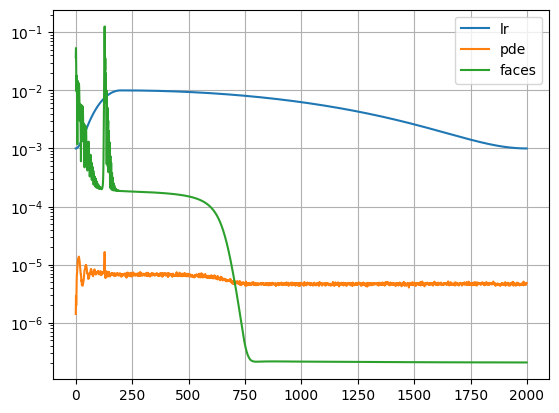

In [ ]:
# plot loss history
import pandas as pd

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

### 1.4. Evaluate

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

Nd=100
x = np.linspace(-0.45,0.45,Nd)
y = np.linspace(-0.45,0.45,Nd)

_x, _y = np.meshgrid(x, y)

grid = np.stack(np.meshgrid(x, y), -1).reshape(-1, 2)
X = torch.from_numpy(grid).float().to(device)
p = pde.eval(X)
p = p.cpu().numpy().reshape((len(_y),len(_x)))

z_train = Y_box.detach().numpy()
xy_train = X_box.detach().numpy()

### 1.5. Visualize

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

#fig = go.Figure(data=[go.Surface(z=(-w1[0]/2)*(2*_x**3+3*_y**3), x=_x, y=_y, showscale=False, opacity=0.3), go.Surface(z=p, x=_x, y=_y) ])
fig = go.Figure(data=[go.Surface(z=-0.38*(_x**3 - _x - 2*_y**3 + 2*_y), x=_x, y=_y, showscale=True, opacity=0.5,colorbar=dict(lenmode='fraction', len=0.6, thickness=18)), # <-- Actual eigenfunction
                      go.Scatter3d(x = xy_train[0,:], y = xy_train[1,:], z = z_train, mode = 'markers', marker = dict(size = 1.5, color = 'black')), # <-- GLA generated training data
                      #go.Surface(z=p, x=_x, y=_y, opacity=0.3, colorbar=dict(lenmode='fraction', len=0.6, thickness=18)) # <-- DNN eigenfunction
                      ])

fig.update_layout(title='$\phi(x)$',
                  autosize=True,
                  width=600, height=600,
                  margin=dict(l=0, r=0, b=15, t=30))

fig.update_layout(scene = dict(
                    xaxis_title='x1',
                    yaxis_title='x2',
                    zaxis_title='g*(x)'))
fig.update_layout(scene_aspectmode='cube')
fig.update_coloraxes(colorbar_xpad=0)
fig.show()


In [ ]:
# Save if all looks A-OK !
from google.colab import files
torch.save(mlp.state_dict(),'checkpoint_GLA.pth')
files.download('checkpoint_GLA.pth')

# **Example 2: 10d Multi-agent system**

In [1]:
%%capture
!pip install networkx
!pip install torchdiffeq
!pip install nangs

In [27]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from torchdiffeq import odeint
import nangs
import math


device = "cuda" if torch.cuda.is_available() else "cpu"
nangs.__version__, torch.__version__

np.random.seed(10)
torch.manual_seed(0)

n = 10 # number of agents
#G = nx.gnc_graph(n)
G = nx.connected_watts_strogatz_graph(n,4,0.2)
Adj = np.zeros((n,n))
idx = list(G.edges())
for i in idx:
  Adj[i]=1
Adj = sp.Matrix(Adj + Adj.T)
x = sp.symbols('x1:'+str(n+1), real=True)

a = sp.matrices.dense.matrix_multiply_elementwise(Adj,sp.Matrix([[np.random.rand()*(1.2*sp.tanh(xa-xb) +
                                                                  sp.sin(xa-xb)) for xa in x] for xb in x]))*sp.ones(n,1)
b = sp.Matrix([1/(1+sp.exp(-x_)) for x_ in x])
f = sp.matrices.dense.matrix_multiply_elementwise(b,a)
f[0] = f[0] - 0.01*x[0]
A = f.jacobian(x).subs([(x_,0) for x_ in x])
E,W = np.linalg.eig(np.array(A.T).astype(np.float64))


f = f - (0.1 - min(E))*sp.Matrix(x)
f = 0.1*f
A = f.jacobian(x).subs([(x_,0) for x_ in x])
E,W = np.linalg.eig(np.array(A.T).astype(np.float64))


fn = f - A*sp.Matrix(x)
g = W.T*fn
f = sp.lambdify(x,tuple(f))
F = lambda t,X : torch.vstack(f(*X))

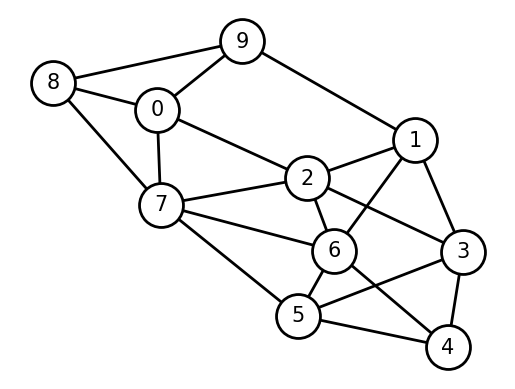

In [28]:
subax1 = plt.subplot(111)
options = {
    "font_size": 15,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}
nx.draw(G, with_labels=True,**options)


### 2.1. EDMD for local approximation

In [29]:
# -*- coding: utf-8 -*-
from sympy.polys.orderings import monomial_key
from sympy.polys.monomials import itermonomials
from numpy.linalg import inv, eig, pinv, det
from scipy.linalg import svd, svdvals, sqrtm
from numpy import diag, dot, real, imag
from IPython import display

# Sample data within epsilon nbhd
def sample_data(dic,N,T, eps):
    X = np.empty((T*N,n))
    Y = np.empty((T*N,n))
    P = 2*np.random.rand(N,n)-1;
    P =  P/np.linalg.norm(P,axis=1).reshape(N,1); P = eps*P*np.random.rand(N,1)
    Start = P
    for k in range(T):
        X[k*N:(k+1)*N,:] = P
        P = P + dt*np.array(f(*P.T)).T
        Y[k*N:(k+1)*N,:] = P
    X = basis_fun(X.T)
    Y = basis_fun(Y.T)
    return X,Y, Start

# Dictionary of monomials for EDMD, deg = 3 i.e. 286-1 total dictionary functions
def basis_fun(X):
    ret = np.ones((len(monomials),X.shape[1]))
    ret[1:,:] = np.array(basis(*X)[1:])
    return ret[1:,:]

deg = 3
monomials = sorted(itermonomials(x, deg), key=monomial_key('grlex', x))
basis = sp.lambdify(x,monomials,"numpy")

# EDMD
N = 100; T=1000; eps = 0.45; dt=0.01
X,Y,Start = sample_data(basis_fun,N,T,eps=eps)

Fphi = np.eye(X.shape[0])
Xtr = X.copy()
Ytr = Y.copy()

A = np.matmul(Ytr,np.linalg.pinv(Xtr))
mu,phi = eig(A.T)
lam = np.log(mu)/dt
K = np.diag(mu)
phi = np.matmul(Fphi,phi)
res_eig = np.abs(np.matmul(phi.T,Y) - np.matmul(K.T,np.matmul(phi.T,X)))
res_eig = np.max(res_eig,axis=1)
#print(np.sort(res_eig))

# Get the stable eigenmodes
stable = np.argwhere(real(lam)<0).T[0]
phi_stable = phi[:,stable]
lam_stable = lam[stable]
sort_idx = np.argsort(real(lam_stable))
phi_stable = phi_stable[:,sort_idx]
lam_stable = lam_stable[sort_idx]

# Sparsify the polynomial coefficients
g = sp.Matrix(real(phi_stable.T)*(abs(real(phi_stable.T))>1e-3))*sp.Matrix(monomials[1:])

[6.82052490e-10 6.82052490e-10 7.36906907e-10 7.75205664e-10
 7.75205664e-10 7.75259934e-10 7.75259934e-10 8.28043092e-10
 8.28043092e-10 8.34041561e-10 8.34041561e-10 8.59293640e-10
 8.59293640e-10 8.91354367e-10 8.91354367e-10 9.24064617e-10
 9.24064617e-10 9.90392292e-10 9.92802308e-10 9.92802308e-10
 1.00713321e-09 1.01062292e-09 1.01821435e-09 1.03119772e-09
 1.03119772e-09 1.05892003e-09 1.05892003e-09 1.07152677e-09
 1.07152677e-09 1.08423973e-09 1.08743148e-09 1.08743148e-09
 1.09475789e-09 1.09475789e-09 1.09588164e-09 1.09588164e-09
 1.10852675e-09 1.12550108e-09 1.12550108e-09 1.13561030e-09
 1.13561030e-09 1.14052906e-09 1.14052906e-09 1.16917511e-09
 1.16917511e-09 1.19364037e-09 1.19364037e-09 1.20384940e-09
 1.20384940e-09 1.20641135e-09 1.20641135e-09 1.20661749e-09
 1.20661749e-09 1.21289867e-09 1.21905038e-09 1.21905038e-09
 1.22556337e-09 1.22556337e-09 1.22679737e-09 1.25106189e-09
 1.25106189e-09 1.25369533e-09 1.25517272e-09 1.25517272e-09
 1.27569045e-09 1.303718

In [30]:
print((lam_stable))
print(real(E))

[-2.76766585+0.14569862j -2.76766585-0.14569862j -2.66504092+0.j
 -2.51988292-0.09848228j -2.51988292+0.09848228j -2.41979094-0.51558016j
 -2.41979094+0.51558016j -2.41513336+0.j         -2.4053816 -0.22087508j
 -2.4053816 +0.22087508j -2.34158856-0.10410491j -2.34158856+0.10410491j
 -2.30325333-0.37101824j -2.30325333+0.37101824j -2.29967893+0.28769603j
 -2.29967893-0.28769603j -2.27032836+0.j         -2.26124083-0.15085051j
 -2.26124083+0.15085051j -2.25276134+0.11809235j -2.25276134-0.11809235j
 -2.25186292+0.j         -2.23830341+0.26576917j -2.23830341-0.26576917j
 -2.21835044+0.22652682j -2.21835044-0.22652682j -2.21548089+0.06161579j
 -2.21548089-0.06161579j -2.19040667+0.32788125j -2.19040667-0.32788125j
 -2.18605369+0.14725172j -2.18605369-0.14725172j -2.18067654+0.j
 -2.16480051+0.19601444j -2.16480051-0.19601444j -2.13775958-0.09389275j
 -2.13775958+0.09389275j -2.12743165-0.02781432j -2.12743165+0.02781432j
 -2.11213414-0.3501722j  -2.11213414+0.3501722j  -2.1053995 -0.1961

In [5]:
from torchdiffeq import odeint

V_ = sp.lambdify(x,g[[-2,-4,-5,-7],0])
V_basis = lambda X: V_(*X)

box={}
eps = 0.45
for i in range(n):
  box[str(x[i])]=[-eps, eps]

m=500
T=100

X = tuple(torch.rand(m, )*(lims[1] - lims[0]) + lims[0] for var, lims in box.items())
X_traj = odeint(F, torch.vstack(X), torch.tensor(np.linspace(0,T,10*T)))
Y = V_basis(X_traj.permute(0,2,1).detach().numpy().T)[:,0,:,:]


In [33]:
#Define the eigenfunction PDE

from nangs import PDE

l1 = real(lam_stable[-1]); g1 = sp.lambdify(x,g[-1])
H = lambda t,X : torch.vstack(f(*tuple(X[0:-1])) + (((1/(t+1e-5))*(-X[-1] + np.exp(-l1*t)*g1(*tuple(X[0:-1])))),))
eps=1.; 0.45;
class Eigen(PDE):
    def computePDELoss(self, inputs, outputs):

        # compute gradients
        grads = self.computeGrads(outputs, inputs)

        # compute loss
        x = tuple([inputs[:, i].cpu().detach() for i in range(n)])
        p = outputs
        u = f(*x)
        pde = -l1*p
        for i in range(n):
          pde = pde + u[i].to(device)*grads[:,i]
        return {'pde': 0.01*pde}

# instantiate pde
pde = Eigen(inputs=tuple([str(x_) for x_ in x]), outputs='p')

# define the sampler
from nangs import RandomSampler
box={}
for i in range(n):
  box[str(x[i])]=[-eps, eps]
sampler = RandomSampler(box, device=device, n_samples=2000)
pde.set_sampler(sampler)

### 2.2. Prepare training data using GLA

In [34]:
samples_per_face = 100
T = 50.
X_box = torch.empty(0)
Y_box = torch.empty(0)
for i in range(n):
  #Face A
  dic=box #This is apparently not a deep copy, caution!
  dic[str(x[i])]=[eps,eps]
  X_ = tuple(torch.rand(samples_per_face,)*(lims[1] - lims[0]) + lims[0] for var, lims in dic.items())
  Y_ = odeint(H, torch.vstack(X_ + (torch.zeros(samples_per_face),)), torch.tensor([0.,T]))[-1][-1]
  Y_box = torch.hstack((Y_box,Y_))
  X_box = torch.hstack((X_box, torch.vstack(X_)))
  #Face B
  dic=box
  dic[str(x[i])]=[-eps,-eps]
  X_ = tuple(torch.rand(samples_per_face,)*(lims[1] - lims[0]) + lims[0] for var, lims in dic.items())
  Y_ = odeint(H, torch.vstack(X_ + (torch.zeros(samples_per_face),)), torch.tensor([0.,T]))[-1][-1]
  Y_box = torch.hstack((Y_box,Y_))
  X_box = torch.hstack((X_box, torch.vstack(X_)))
  dic[str(x[i])]=[-eps,eps]

#Interior
samples_interior = 1000
X_ = tuple(torch.rand(samples_interior,)*(lims[1] - lims[0]) + lims[0] for var, lims in dic.items())
Y_ = odeint(H, torch.vstack(X_ + (torch.zeros(samples_interior),)), torch.tensor([0.,T]))[-1][-1]
Y_box = torch.hstack((Y_box,Y_))
X_box = torch.hstack((X_box, torch.vstack(X_)))

In [35]:

class Dirichlet(nangs.bocos.boco.Boco):
    def __init__(self, X_box, Y_box, name="dirichlet"):
        super().__init__(name)
        self.X_ = X_box.T
        self.Y_ = Y_box

    def validate(self, inputs, outputs):
        super().validate()

    def computeLoss(self, model, criterion, inputs, outputs):
        y_hat = model(self.X_)[:,0]
        y = self.Y_
        return {self.name: criterion(y, y_hat)}

initial_condition = Dirichlet(X_box.to(device),Y_box.to(device),"faces")
pde.add_boco(initial_condition)

### 2.3. Train

In [36]:
# solve
from nangs import MLP

LR = 1e-2
N_STEPS = 2000
NUM_LAYERS = 3
NUM_HIDDEN = 128

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

{'pde': 1e-05, 'faces': 5e-05}: 100%|██████████| 2000/2000 [05:21<00:00,  6.22it/s]

CPU times: user 4min 45s, sys: 6 s, total: 4min 51s
Wall time: 5min 21s


<Axes: >

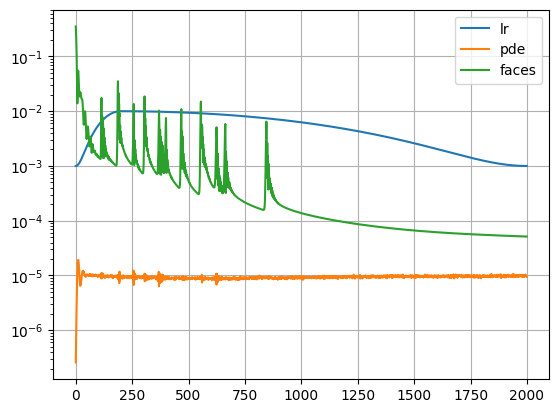

In [37]:
# plot loss history
import pandas as pd

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

In [ ]:
# Save stuff as needed

import pickle
from google.colab import files

# Save dynamics
with open('a.pickle', 'wb') as outf:
    pickle.dump(a, outf)
files.download('a.pickle')

# Save learnt DNN eigenfunction corresponding to eigenvalue l1
torch.save(mlp.state_dict(),'checkpoint_GLA_' + str(l1) + '.pth')
files.download('checkpoint_GLA_' + str(l1) + '.pth')

### 2.4. Evaluate

In [38]:
m=200
T=10
X = tuple(torch.rand(m,)*(lims[1] - lims[0]) + lims[0] for var, lims in box.items())
X_traj = odeint(H, torch.vstack(X + (torch.zeros(m),)), torch.tensor(np.linspace(0,T,10*T)))#,method='rk4',options=dict(step_size=1e-2))#[:,0:-1,:]

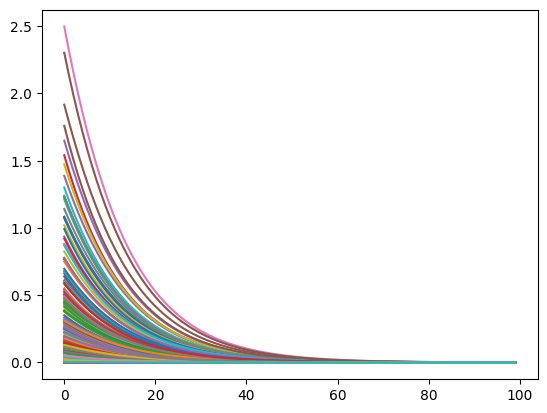

In [40]:
p = pde.eval(X_traj.to(device).permute(0,2,1)[:,:,0:n])
p = p.cpu().numpy()[:,:,0]
plt.plot(p[0:100,:]**2); # Lyapunov basis functions

### 2.5. Load pretrained models (each model corresponds to one particular eigenfunction)

In [32]:
%%capture
!pip install torchdiffeq
!pip install nangs
!pip install -U kaleido

In [ ]:
import torch
from nangs import MLP
from google.colab import files

import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from torchdiffeq import odeint
import nangs
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
nangs.__version__, torch.__version__

#files.upload(); # trained DNN params
#files.upload(); # dynamics

('2021.12.06', '1.13.1+cu116')

In [49]:
import glob

dir_path = r'/content/*.pth*'
res = glob.glob(dir_path)

In [50]:
import pickle

NUM_LAYERS = 3
NUM_HIDDEN = 128

mlp_list = []
for i,name in enumerate(res):
  print(name)
  state_dict = torch.load(name)
  mlp = MLP(10,1, NUM_LAYERS, NUM_HIDDEN).to(device)
  mlp.load_state_dict(state_dict)
  mlp_list = mlp_list + [mlp]

V_basis = lambda X : torch.concat([mlp(X) for mlp in mlp_list],axis=2)

with open('/content/a.pickle', 'rb') as inf:
   a = pickle.loads(inf.read())

n = 10 # number of agents
x = sp.symbols('x1:'+str(n+1), real=True)

b = sp.Matrix([1/(1+sp.exp(-x_)) for x_ in x])
f = sp.matrices.dense.matrix_multiply_elementwise(b,a)
f[0] = f[0] - 0.01*x[0]
A = f.jacobian(x).subs([(x_,0) for x_ in x])
E,W = np.linalg.eig(np.array(A.T).astype(np.float64))

f = f - (0.1 - min(E))*sp.Matrix(x)
f = 0.1*f
A = f.jacobian(x).subs([(x_,0) for x_ in x])
E,W = np.linalg.eig(np.array(A.T).astype(np.float64))

f = sp.lambdify(x,tuple(f))
F = lambda t,X : torch.vstack(f(*X))


FileNotFoundError: ignored

In [37]:
from torchdiffeq import odeint
box={}
eps = 1.5
for i in range(n):
  box[str(x[i])]=[-eps, eps]

m=500
T=100

X = tuple(torch.rand(m,)*(lims[1] - lims[0]) + lims[0] for var, lims in box.items())
X_traj = odeint(F, torch.vstack(X), torch.tensor(np.linspace(0,T,10*T)))
Y = V_basis(X_traj.permute(0,2,1)).detach().numpy()

RuntimeError: ignored

In [ ]:
Y = np.hstack([Y,Y_])

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

df = pd.DataFrame(Y[:,:,0])
#fig = px.line(df,line_color='red')
fig = go.Figure()
# Create and style traces
x = np.linspace(0,T,10*T)
coeff = np.random.rand(4);
coeff = np.round(coeff/np.sum(coeff),2)
np.dot(Y,coeff)
for i in range(m):
  #y = Y[:,i,0]
  y = np.dot(0.5*Y**2,coeff)[:,i]
  #fig.add_trace(go.Scatter(x=x[0:100],y=y[0:100], showlegend=False,line=dict(color="rgba( 143, 82, 244,0.2)", width=2)))
  fig.add_trace(go.Scatter(x=x[0:100],y=y[0:100], showlegend=False,line=dict(color="rgba(220,20,60, 0.2)", width=2)))

#fig.update_layout(xaxis_title='t',yaxis_title='V<sub>i</sub>(x(t))')
fig.update_layout(xaxis_title='t',yaxis_title='V(x(t))')
fig.update_xaxes(title_standoff = 0, title_font_size=25, tickfont_size=25)
fig.update_yaxes(title_standoff = 0, title_font_size=25, tickfont_size=25)
#fig.update_layout(title_text='λ<sub>i</sub> = 0.69', title_x=0.5, title_pad=dict(b=0), title_font_size=25)
alpha = [c for c in coeff]
fig.update_layout(title_text='α = '+ str(alpha), title_x=0.5, title_pad=dict(b=0), title_font_size=25)
fig.update_layout(width=600, height=400, margin=dict(t=50,b=5,r=20,l=100))

# Show plot
fig.show()


In [ ]:
import plotly.io as pio
pio.write_image(fig, 'V.png', scale=4)

In [48]:
url = f"https://github.com/dekovski/Koopman_Lyapunov/blob/main/Van%20der%20Pol/Neural_Lyapunov/saved/limit_cycle.npy"
!wget {url}

--2023-07-07 14:05:38--  https://github.com/dekovski/Koopman_Lyapunov/blob/main/Van%20der%20Pol/Neural_Lyapunov/saved/limit_cycle.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5336 (5.2K) [text/plain]
Saving to: ‘limit_cycle.npy.2’

limit_cycle.npy.2   100%[===================>]   5.21K  --.-KB/s    in 0s      

2023-07-07 14:05:38 (79.1 MB/s) - ‘limit_cycle.npy.2’ saved [5336/5336]

